In [45]:
pip install -U langgraph langchain_community langchain_anthropic langchain-tavily langchain_experimental

Note: you may need to restart the kernel to use updated packages.


In [46]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [47]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [48]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

In [52]:
from typing import List, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

def make_supervisor_node(llm: BaseChatModel, members: List[str]):
    options = ["FINISH"] + members

    # Build the Literal type dynamically:
    NextType = Literal[tuple(options)]  # type: ignore

    class Router(TypedDict):
        """Worker-to-route mapping. 'next' must be one of the options."""
        next: NextType

    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the "
        f"following workers: {members}. Given the following user request, "
        "respond with the worker to act next. Each worker will perform a "
        "task and respond with their results and status. When finished, "
        "respond with FINISH."
    )

    def supervisor_node(state: StateGraph[MessagesState]):
        # Gather messages to present to the LLM router:
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]

        # Invoke the LLM with the structured Router output:
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]

        # Map "FINISH" to END sentinel:
        if goto == "FINISH":
            return Command(goto=END, update={"next": "FINISH"})

        # Otherwise route to the worker name:
        return Command(goto=goto, update={"next": goto})

    return supervisor_node


In [53]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [54]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

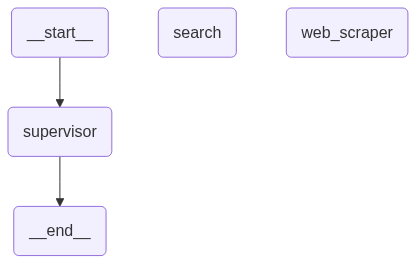

In [55]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [56]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, "The Eras Tour," has U.S. dates scheduled for 2024. Some of the key dates are:\n\n- Miami: October 18-20, 2024\n- New Orleans: October 25-27, 2024\n- Indianapolis: November 1-3, 2024\n- Toronto, Canada: She will wrap up on November 23, 2024\n\nIn 2023, she began her second leg internationally from August and concluded the U.S. part in early August. For more details, you can visit [NJ.com](https://www.nj.com/live-entertainment/2023/03/taylor-swift-tour-2023-full-schedule-dates-where-to-buy-tickets.html) or [Holler Country](https://holler.country/news/general/taylor-swift-concert-tour-2023-tickets-and-dates).', additional_kwargs={}, response_metadata={}, name='search', id='e5de7a0d-6026-488e-858b-89f264815263')]}}
---
{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, "The Eras Tour," has U.S. dates scheduled for 20

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'supervisor': {'next': 'FINISH'}}
---


In [58]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [59]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

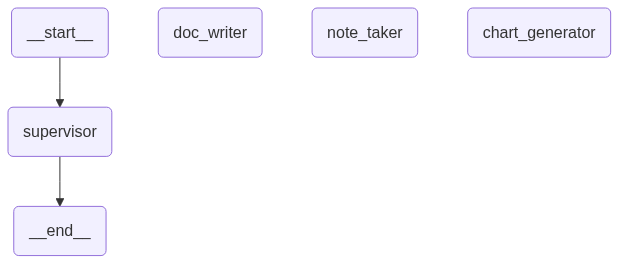

In [60]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [61]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem "Mystique of the Feline" has been written and saved to a file named "Mystique_of_the_Feline.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='53ef85c7-c992-4524-a122-87936cadcfeb')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem "Mystique of the Feline" has been created and saved as "Mystique_of_the_Feline_Outline.txt". Here are the main points:\n\n1. Introduction: Setting the Scene in Moonlight\n2. The Enigma and Mystery of Cats\n3. Their Graceful Movements and Silent Hunting\n4. Daylight Playfulness and Curious Nature\n5. The Solitary but Fiery Spirit of Cats\n6. Peaceful Presence and Soothing Purrs\n7. The Endless Wonder and Timeless Bond with Humans', additional_kwargs={}, response_metadata={}, name='note_taker', id='a24639b4-6cd3-4546-8b59-a3ac23206e43')]}}
---


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'supervisor': {'next': 'FINISH'}}
---


In [62]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [63]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

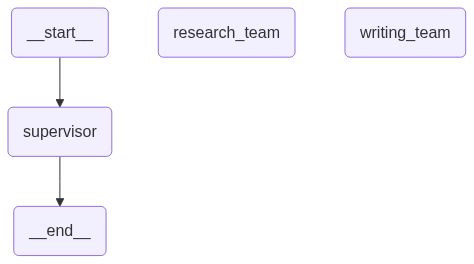

In [64]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

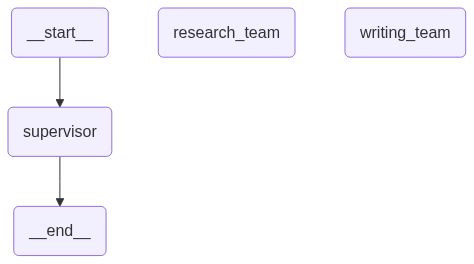

In [65]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [66]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'research_team': {'messages': [HumanMessage(content='### Overview of AI Agents\n\nAI agents are advanced software entities designed to autonomously comprehend, plan, and execute tasks. Utilizing artificial intelligence (AI) and machine learning (ML) algorithms, these agents perceive their environment, make informed decisions, and take actions to achieve predetermined goals. They are capable of operating without human intervention and often use large language models (LLMs) to enhance communication and adaptability in dynamic situations.\n\n### Applications Across Industries\n\nAI agents are transforming various sectors:\n\n1. **Healthcare**: In healthcare, AI agents assist in treatment planning, drug management, and automating routine tasks, allowing medical professionals to dedicate more time to critical issues.\n\n2. **Finance**: They play a role in risk assessment, fraud detection, and automated trading systems, enhancing the efficiency and accuracy of financial operations.\n\n3. **

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'writing_team': {'messages': [HumanMessage(content='The contents of the documents "Overview of AI Agents" and its outline are as follows:\n\n### "Overview of AI Agents":\n\n1. **Overview of AI Agents**\n\n   AI agents are advanced software entities designed to autonomously comprehend, plan, and execute tasks. Utilizing artificial intelligence (AI) and machine learning (ML) algorithms, these agents perceive their environment, make informed decisions, and take actions to achieve predetermined goals. They are capable of operating without human intervention and often use large language models (LLMs) to enhance communication and adaptability in dynamic situations.\n\n2. **Applications Across Industries**\n\n   AI agents are transforming various sectors:\n\n   - **Healthcare**: In healthcare, AI agents assist in treatment planning, drug management, and automating routine tasks, allowing medical professionals to dedicate more time to critical issues.\n\n   - **Finance**: They play a role in 

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'writing_team': {'messages': [HumanMessage(content='The documents "Overview of AI Agents" and "Overview of AI Agents Outline" have been successfully created and saved.', additional_kwargs={}, response_metadata={}, name='writing_team', id='464a4e12-8d6b-4878-9ed2-278c653f9e6b')]}}
---


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'supervisor': {'next': 'FINISH'}}
---
